# Sentimental Analysis Using Rule_based and Pretrained Models
## A comparism study of sentimental analysis  VADER(Valence Aware Dictionary mad Sentiment Reasoner) and Roberta Pretrained model from Huggingface Pipeline

## Mounting my Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')##

Mounted at /content/drive


In [2]:
# Installing the transformer for the analysis
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.9 MB/s eta 0:00:00


## Installing Keras-Preprocessing for the LSTM model

In [3]:
pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 817.8 kB/s eta 0:00:00


## Importing all the libraries needed for the classification

In [4]:
# Impordung the general Modules needed for the analysis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


plt.style.use("ggplot")

#Importing the nltk modules needed for vader analysis

import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# importing the transformer modules needed for Roberta model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# Importing the CNN-LSTM and Gridsearch modules for the classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
# GridSearch
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# Importing K form Keras to clear backend ofter running a model. Thi will prevent a model from learning from hat it has learnt before
import keras.backend as K




## Reading in the Brazilian women e-cormmerce dataset for the reveiws text sentiment mining

In [5]:
# importing the dataset
df = pd.read_csv("/content/drive/MyDrive/Applied AI Assesment/WCE-Commerce-Reviews.csv")

# Veiwing the first five rows of our dataset
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
# Change the name of the unnamed columns. This column will serve as the row indexing for the analysis
df.rename(columns ={"Unnamed: 0":"ID"}, inplace=True)

## For this analysis we only need the review column, the Age and Rating column fro this analysis.  I included the age colum so i can analyse the type of sentiment prevaleun in different age group

In [7]:
df = df[["ID", "Age", "Review Text", "Rating", "Class Name"]]
df

,ID,Age,Review Text,Rating,Class Name
0,0,33,Absolutely wonderful - silky and sexy and comf...,4,Intimates
1,1,34,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,2,60,I had such high hopes for this dress and reall...,3,Dresses
3,3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants
4,4,47,This shirt is very flattering to all due to th...,5,Blouses
...,...,...,...,...,...
23481,23481,34,I was very happy to snag this dress at such a ...,5,Dresses
23482,23482,48,"It reminds me of maternity clothes. soft, stre...",3,Knits
23483,23483,31,"This fit well, but the top was very see throug...",3,Dresses
23484,23484,28,I bought this dress for a wedding i have this ...,3,Dresses


## Data Cleaning and Exploratory Data Analysis

In [8]:
# The review column has 845 missing values. These need to be drop since i wan to work only unique review entries
df.isna().sum()

ID               0
Age              0
Review Text    845
Rating           0
Class Name      14
dtype: int64

## Droping all rows that has missing values

In [9]:
df.dropna(inplace=True)
df.isna().sum()

ID             0
Age            0
Review Text    0
Rating         0
Class Name     0
dtype: int64

In [10]:
print(df.shape)

(22628, 5)


## Counting the total number of review score to understand the distribution of The Rating from the customers


In [8]:
sns.set(font_scale=1.2)
sns.set_style("white")


Plot saved to /content/drive/MyDrive/Applied AI Assesment/rating.png


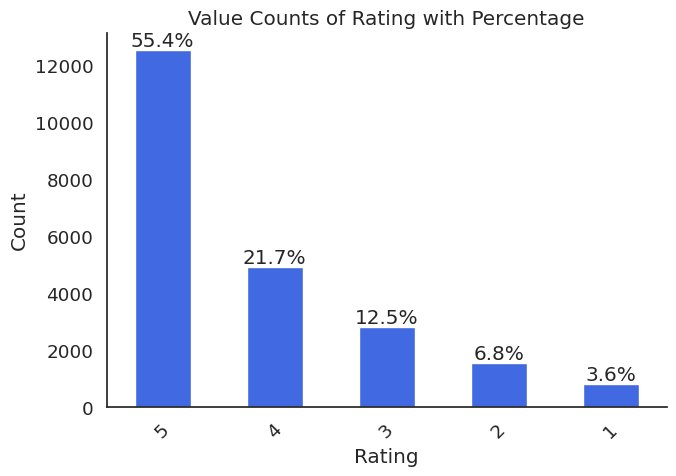

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_value_counts_with_percentage(data_frame, column_name, figsize=(7, 5), save_path=None):

    plt.figure(figsize=figsize)
    value_counts = data_frame[column_name].value_counts()
    total_count = len(data_frame[column_name])

    ax = value_counts.plot(kind='bar', color='royalblue')
    plt.xticks(rotation=45)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

    ax.spines[['top', 'right']].set_visible(False)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Value Counts of {column_name} with Percentage')
    plt.tight_layout()
    if save_path:
      plt.savefig(save_path)
      print(f"Plot saved to {save_path}")
    else:
        plt.show()


drive_path = "/content/drive/MyDrive/Applied AI Assesment/rating.png"
plot_value_counts_with_percentage(df, 'Rating', save_path=drive_path)


# The rule_based sentiment mining will be carried out using VADER(Valence Aware Dictionary for Sentiment Reasoning)

## Dowloading the nltk sub_packages for the VADER sentiment Analysis

In [13]:
# NLTK sub_packages for VADER Sentiment Mining
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Exploring basic nltk sentiment analysis operations

In [14]:
first_review_text = df["Review Text"][10]
print(first_review_text)

# Using tokenize to split the sentencees into words
tokens = nltk.word_tokenize(first_review_text)

# Using the pos_tag function to tag each word to their spcific paths of speech
tagged = nltk.pos_tag(tokens)


# using the nltk chunks
chunks = nltk.chunk.ne_chunk(tagged)
chunks.pprint()

print(tokens[:10])
print(tagged[:10])


Dress runs small esp where the zipper area runs. i ordered the sp which typically fits me and it was very tight! the material on the top looks and feels very cheap that even just pulling on it will cause it to rip the fabric. pretty disappointed as it was going to be my christmas dress this year! needless to say it will be going back.
(S
  (GPE Dress/NNP)
  runs/VBZ
  small/JJ
  esp/NN
  where/WRB
  the/DT
  zipper/NNP
  area/NN
  runs/VBZ
  ./.
  i/NN
  ordered/VBD
  the/DT
  sp/NN
  which/WDT
  typically/RB
  fits/VBZ
  me/PRP
  and/CC
  it/PRP
  was/VBD
  very/RB
  tight/JJ
  !/.
  the/DT
  material/NN
  on/IN
  the/DT
  top/JJ
  looks/NNS
  and/CC
  feels/NNS
  very/RB
  cheap/VBP
  that/IN
  even/RB
  just/RB
  pulling/VBG
  on/IN
  it/PRP
  will/MD
  cause/VB
  it/PRP
  to/TO
  rip/VB
  the/DT
  fabric/NN
  ./.
  pretty/RB
  disappointed/JJ
  as/IN
  it/PRP
  was/VBD
  going/VBG
  to/TO
  be/VB
  my/PRP$
  christmas/NN
  dress/NN
  this/DT
  year/NN
  !/.
  needless/NN
  to/TO
  

# Start of VADER
## This uses a "bag of words" approach:
    1. Stop words are removed
    2. Each words is scored and combine to a total score
    3. Vader does not account for relationship between words; and important part of humans speech

In [15]:
# Calling our sentiment analyzer and assigning it to a function sia
vader_SA = SentimentIntensityAnalyzer()
# Testing the VADER sentiment analyser function on an negative sentence to understand the scores in the sentence
print(vader_SA.polarity_scores("Everyth thig about this assessment is bad"))

# Testing the VADER sentiment analyser function on an posiive sentence to understand the scores in the sentence
print(vader_SA.polarity_scores("I am happy i joined Ojie class. His indepth analysis rreally help us to understand the AI class"))

{'neg': 0.368, 'neu': 0.632, 'pos': 0.0, 'compound': -0.5423}
{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'compound': 0.7506}


## Using a loop to run the VADER sentiment analyser on the entire "Review Text" column

In [16]:
# Running the polarity score on the wntire dataset using a loop
vader_rev_Score = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["Review Text"]
    myid = row["ID"]
    vader_rev_Score[myid] = vader_SA.polarity_scores(text)
# printing the VADER Polarity Scores
vader_rev_Score

  0%|          | 0/22628 [00:00<?, ?it/s]

{0: {'neg': 0.0, 'neu': 0.272, 'pos': 0.728, 'compound': 0.8932},
 1: {'neg': 0.0, 'neu': 0.664, 'pos': 0.336, 'compound': 0.9729},
 2: {'neg': 0.027, 'neu': 0.792, 'pos': 0.181, 'compound': 0.9427},
 3: {'neg': 0.226, 'neu': 0.34, 'pos': 0.434, 'compound': 0.5727},
 4: {'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound': 0.9291},
 5: {'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'compound': 0.9419},
 6: {'neg': 0.023, 'neu': 0.881, 'pos': 0.096, 'compound': 0.8004},
 7: {'neg': 0.046, 'neu': 0.901, 'pos': 0.053, 'compound': -0.0909},
 8: {'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'compound': 0.7175},
 9: {'neg': 0.12, 'neu': 0.753, 'pos': 0.126, 'compound': -0.3724},
 10: {'neg': 0.044, 'neu': 0.877, 'pos': 0.079, 'compound': 0.3578},
 11: {'neg': 0.0, 'neu': 0.319, 'pos': 0.681, 'compound': 0.8927},
 12: {'neg': 0.026, 'neu': 0.899, 'pos': 0.075, 'compound': 0.552},
 13: {'neg': 0.029, 'neu': 0.833, 'pos': 0.138, 'compound': 0.8036},
 14: {'neg': 0.074, 'neu': 0.752, 'pos': 0.174, 'compound': 0

## Converting the results of the VADER sentiment analyser to a dataframe and joing it to the dataframe

In [17]:
# Converting our results to a pandas dataframe
vader_results = pd.DataFrame(vader_rev_Score).T

vaders = vader_results.reset_index().rename(columns={"index": "ID"})

# Mergeing it to our original dataframe
vaderdf = vaders.merge(df, how="left")

# dataframe of our vaders scores and meta-data
vaderdf.head()

,ID,neg,neu,pos,compound,Age,Review Text,Rating,Class Name
0,0,0.000,0.272,0.728,0.8932,33,Absolutely wonderful - silky and sexy and comf...,4,Intimates
1,1,0.000,0.664,0.336,0.9729,34,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,2,0.027,0.792,0.181,0.9427,60,I had such high hopes for this dress and reall...,3,Dresses
3,3,0.226,0.340,0.434,0.5727,50,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants
4,4,0.000,0.700,0.300,0.9291,47,This shirt is very flattering to all due to th...,5,Blouses


## Visualizing our dataset to know if the vader score values is synonimous to rating given by the user


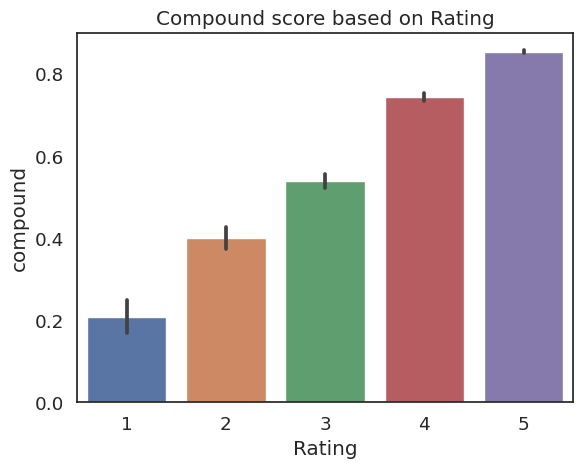

In [18]:
# Plot of the Compound Scores against the Rating
ax1 = sns.barplot(data=vaderdf, x = "Rating", y="compound" )
ax1.set_title("Compound score based on Rating")
plt.savefig("/content/drive/MyDrive/Applied AI Assesment/vader.png")

# Plotting the Polarity score for Negative, Positive, and Neutral for the VADER analyzer

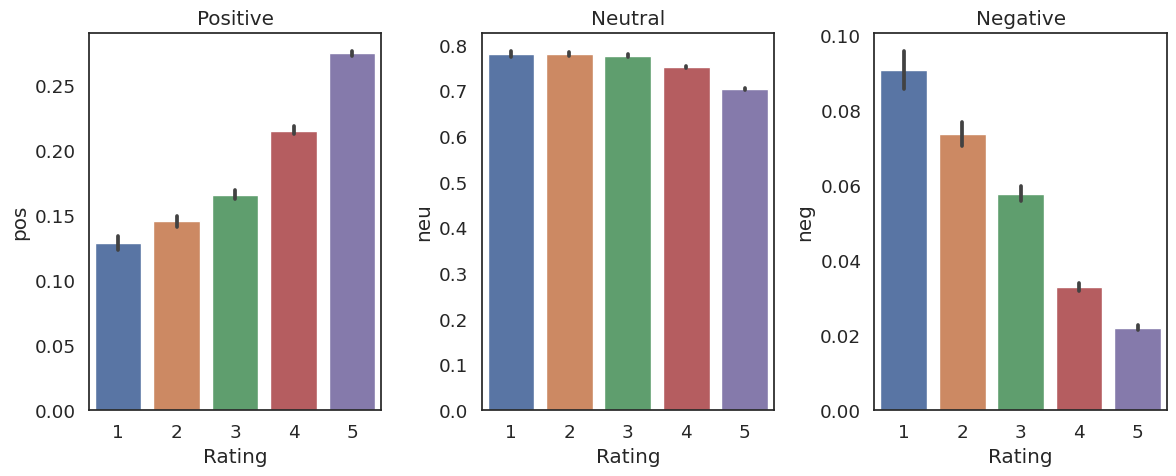

In [19]:
# Defining the plot parameters, and this
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.barplot(data=vaderdf, x = "Rating", y="pos", ax=axes[0])
sns.barplot(data=vaderdf, x = "Rating", y="neu", ax=axes[1])
sns.barplot(data=vaderdf, x = "Rating", y="neg", ax= axes[2])
# setting the plot tiltles
axes[0].set_title("Positive")
axes[1].set_title("Neutral")
axes[2].set_title("Negative")
# Defining the plot_layout and the saving the plot
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Applied AI Assesment/Vader_polarity.png")
plt.show()

# Using Roberto Pre-Trained models to analyzer the polarity in the Reveiw Text of the dataset
## Downloading the necessary model weights to be used for the roberto model. For this model, we will be using the weights for roberta model trained with twitter dataset

In [20]:
# Import a Roberta pretrained model using oue review1 sample
MODEL =  f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

## Testing the Roberta Pretrained model on the first_review_text to compare with the performance of VADER

In [21]:
# Run our review1 on roberta
encoded_text =tokenizer(first_review_text, return_tensors="pt")
output = model(**encoded_text)


roberta_scores = output[0][0].detach().numpy()
scores = softmax(roberta_scores)

scores
scores_dict = {
    "roberta_neg": scores[0],
    "roberta_neu": scores[1],
    "roberta_pos": scores[2]

}
print(scores_dict)

{'roberta_neg': 0.8403664, 'roberta_neu': 0.13353212, 'roberta_pos': 0.026101433}


## Defining a function that takes and "Review Text Colum  and calculates the polarity scores of the each review text using the roBERTa pretrained models.



In [22]:
# Defining a function that runs through our dataset and returns a dictionary of our scores using roberta

def polarity_scores_roberta(review1):
    # Run our review1 on roberta
    encoded_text_roberta =tokenizer(review1, return_tensors="pt")
    output = model(**encoded_text_roberta)
    roberta_scores = output[0][0].detach().numpy()
    scores = softmax(roberta_scores)
    scores_dict = {
    "roberta_neg": scores[0],
    "roberta_neu": scores[1],
    "roberta_pos": scores[2]

    }
    return scores_dict

### Using a for loop to map the results of the roBERTa pre-trained model and the VADER model to a dataframe named results_df

In [24]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["Review Text"]
    myid = row["ID"]
    vader_result = vader_SA.polarity_scores(text)
    vader_result_rename ={}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result_rename, **roberta_result}
    res[myid] = both

  0%|          | 0/22628 [00:00<?, ?it/s]

### Converting the results to a dataframe

In [25]:
# Transposing the results while converting them to pandas data frame
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {"index": "ID"})
results_df = results_df.merge(df, how="left")

# Displaying the results of the VADER and Roberta results
results_df



,ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Age,Review Text,Rating,Class Name
0,0,0.000,0.272,0.728,0.8932,0.002245,0.010576,0.987180,33,Absolutely wonderful - silky and sexy and comf...,4,Intimates
1,1,0.000,0.664,0.336,0.9729,0.001609,0.007436,0.990955,34,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,2,0.027,0.792,0.181,0.9427,0.366803,0.380140,0.253057,60,I had such high hopes for this dress and reall...,3,Dresses
3,3,0.226,0.340,0.434,0.5727,0.002247,0.004622,0.993131,50,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants
4,4,0.000,0.700,0.300,0.9291,0.001239,0.006733,0.992028,47,This shirt is very flattering to all due to th...,5,Blouses
...,...,...,...,...,...,...,...,...,...,...,...,...
22623,23481,0.065,0.547,0.388,0.9152,0.001105,0.006981,0.991914,34,I was very happy to snag this dress at such a ...,5,Dresses
22624,23482,0.068,0.735,0.197,0.6652,0.129048,0.323072,0.547880,48,"It reminds me of maternity clothes. soft, stre...",3,Knits
22625,23483,0.000,0.704,0.296,0.9343,0.046035,0.150881,0.803084,31,"This fit well, but the top was very see throug...",3,Dresses
22626,23484,0.068,0.812,0.120,0.6692,0.390427,0.373043,0.236531,28,I bought this dress for a wedding i have this ...,3,Dresses


## Visualizing the polarity scores of the model using pairplot

In [ ]:
# # Getting the columns of the dataframe
# results_df.columns

### Displaying the results of VADER Polarity scores Using Pairplot

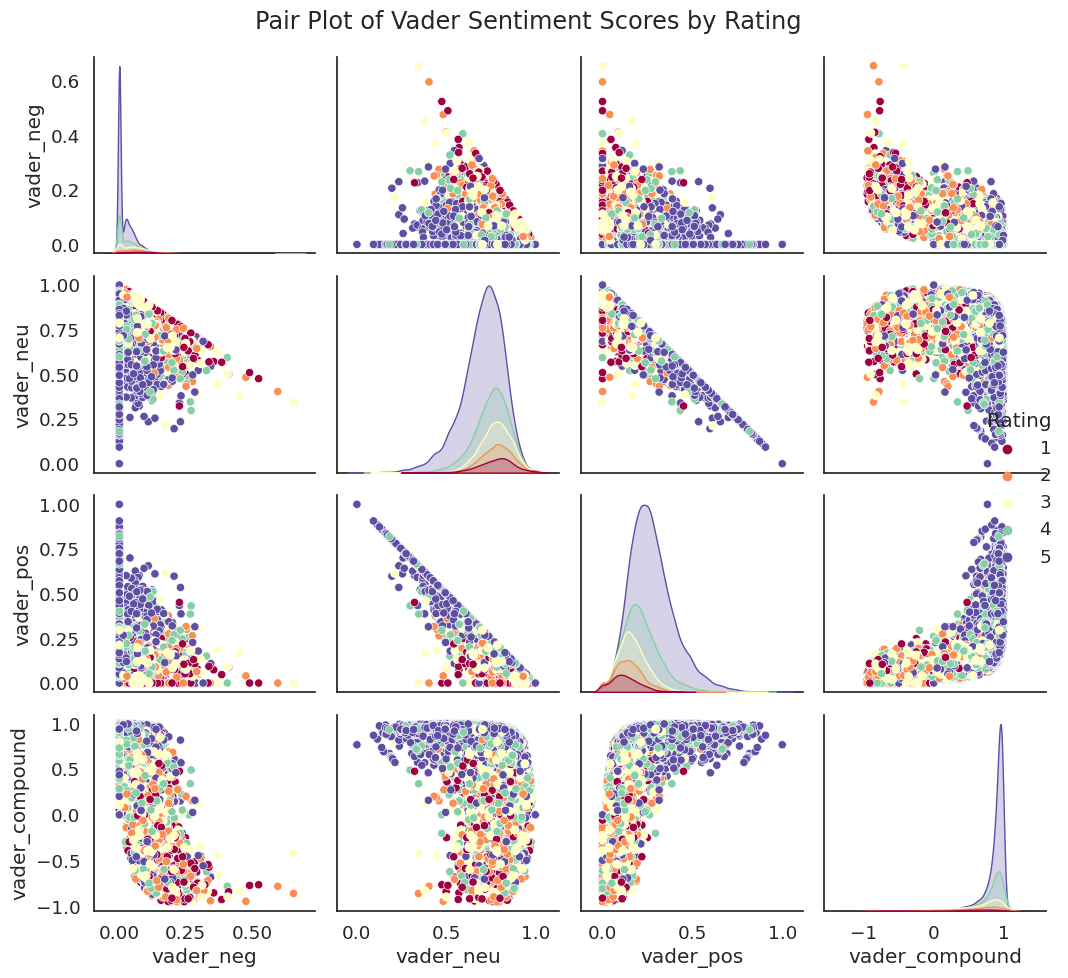

In [26]:
# Pairplot of the VADER polarity Score
VPP = sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'], hue="Rating", palette="Spectral")
VPP.fig.suptitle("Pair Plot of Vader Sentiment Scores by Rating")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Applied AI Assesment/Vader_polarityPairplot.png")
plt.show()

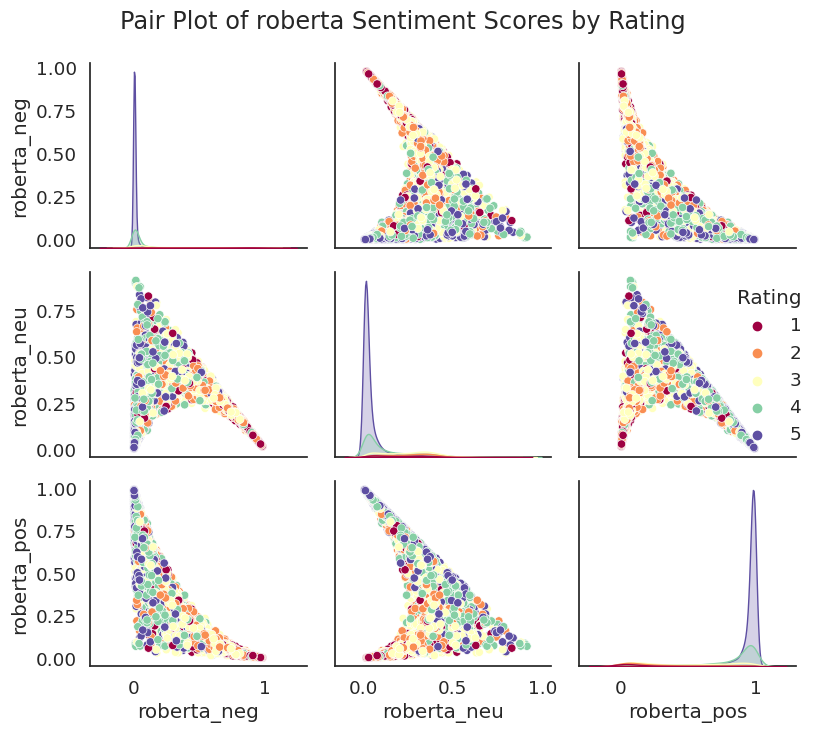

In [27]:
#  Pairplot of the Roberta polarity scores
RPP =sns.pairplot(data=results_df, vars =['roberta_neg', 'roberta_neu', 'roberta_pos'],hue="Rating", palette="Spectral")
RPP.fig.suptitle("Pair Plot of roberta Sentiment Scores by Rating")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Applied AI Assesment/roberta_polarityPairplot.png")
plt.show()

## Using a function to convert the polarity scores of the roberta model into sentiment values of positive negative or neutral

In [36]:
# Roberta polarity converter
def determine_sentiment(row):
    max_value = max(row['roberta_pos'], row['roberta_neu'], row['roberta_neg'])
    if row['roberta_pos'] == max_value:
        return 'positive'
    elif row['roberta_neu'] == max_value:
        return 'neutral'
    else:
        return 'negative'

results_df['roberta_sentiment'] = results_df.apply(determine_sentiment, axis=1)



## Using a function to convert the polarity scores of the VADER model into sentiment values of positive negative or neutral.
## One notable difference with defining the polairty of a VADER model is that you have to personally define the threshold to use and convert the polarity score to either negative, positive or neutral

### For this analysis I choose values above 0.6 as positive and values below 0.4 and negatvie and he values inbetween and neutral

In [37]:


def add_sentiment_column(data_frame, input_column_name, new_column_name):
    def determine_sentiment(value):
        if value > 0.6:
            return 'positive'
        elif value < 0.4:
            return 'negative'
        else:
            return 'neutral'

    data_frame[new_column_name] = data_frame[input_column_name].apply(determine_sentiment)

# Sample data


# Call the function to add the new sentiment column
add_sentiment_column(results_df, 'vader_compound', 'VADER_sentiment')

# Display the modified DataFrame
results_df


,ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Age,Review Text,Rating,Class Name,roberta_sentiment,VADER_sentiment
0,0,0.000,0.272,0.728,0.8932,0.002245,0.010576,0.987180,33,Absolutely wonderful - silky and sexy and comf...,4,Intimates,positive,positive
1,1,0.000,0.664,0.336,0.9729,0.001609,0.007436,0.990955,34,Love this dress! it's sooo pretty. i happene...,5,Dresses,positive,positive
2,2,0.027,0.792,0.181,0.9427,0.366803,0.380140,0.253057,60,I had such high hopes for this dress and reall...,3,Dresses,neutral,positive
3,3,0.226,0.340,0.434,0.5727,0.002247,0.004622,0.993131,50,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,positive,neutral
4,4,0.000,0.700,0.300,0.9291,0.001239,0.006733,0.992028,47,This shirt is very flattering to all due to th...,5,Blouses,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22623,23481,0.065,0.547,0.388,0.9152,0.001105,0.006981,0.991914,34,I was very happy to snag this dress at such a ...,5,Dresses,positive,positive
22624,23482,0.068,0.735,0.197,0.6652,0.129048,0.323072,0.547880,48,"It reminds me of maternity clothes. soft, stre...",3,Knits,positive,positive
22625,23483,0.000,0.704,0.296,0.9343,0.046035,0.150881,0.803084,31,"This fit well, but the top was very see throug...",3,Dresses,positive,positive
22626,23484,0.068,0.812,0.120,0.6692,0.390427,0.373043,0.236531,28,I bought this dress for a wedding i have this ...,3,Dresses,negative,positive


## Saving the new dataset to a CSV dataframe

In [38]:
results_df.to_csv('/content/drive/MyDrive/Applied AI Assesment/results_df.csv')

### Plotting the roberta and VADER sentiment value_counts to compare with the results of original Rating distribution

In [18]:
#importing the dataset
results_df = pd.read_csv("/content/drive/MyDrive/Applied AI Assesment/results_df.csv")


## Plotting the sentiment count values for the roberta Sentiments analysis

Plot saved to /content/drive/MyDrive/Applied AI Assesment/robert_sentiment.png


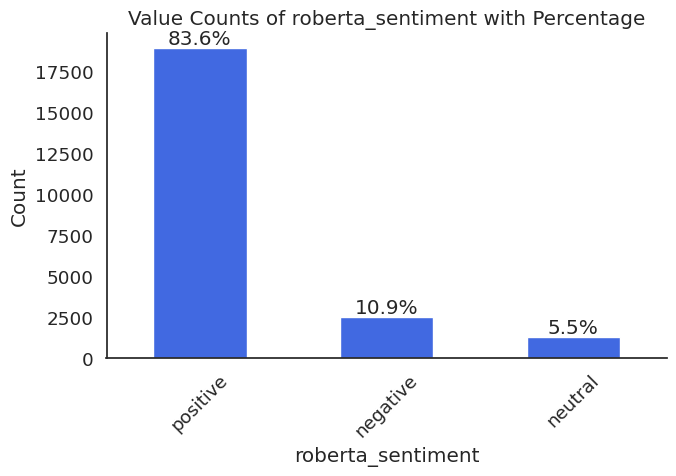

In [39]:
# Percentage plot of the value of the sentiment scores
drive_path = "/content/drive/MyDrive/Applied AI Assesment/robert_sentiment.png"
plot_value_counts_with_percentage(results_df, 'roberta_sentiment', save_path=drive_path )

t
## Plotting the sentiment count values for the VADER Sentiments analysis

Plot saved to /content/drive/MyDrive/Applied AI Assesment/vader_sentiment.png


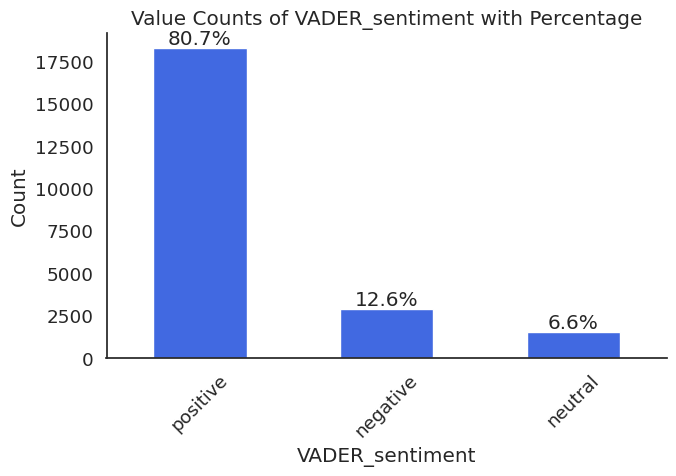

In [40]:
# Percentage plot of the value of the sentiment scores
drive_path = "/content/drive/MyDrive/Applied AI Assesment/vader_sentiment.png"
plot_value_counts_with_percentage(results_df, 'VADER_sentiment', save_path=drive_path)

# Examining the age group most likely to give a Negative review. this will help to in marketting and product design
## Defining a function that takes the age group and puts them in bands of 10 years

In [6]:


# Function that creates age bandsof 10 years
def age_group(age):
    if age < 0:
        return "Invalid"
    elif age < 10:
        return "0-9"
    elif age < 20:
        return "10-19"
    elif age < 30:
        return "20-29"
    elif age < 40:
        return "30-39"
    elif age < 50:
        return "40-49"
    elif age < 60:
        return "50-59"
    elif age < 70:
        return "60-69"
    elif age < 80:
        return "70-79"
    elif age < 90:
        return "80-89"
    else:
        return "90+"



# Apply the function and create a new 'age_group' column
results_df["age_group"] = results_df['Age'].apply(age_group)
results_df.head()

,Unnamed: 0,ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Age,Review Text,Rating,Class Name,roberta_sentiment,VADER_sentiment,age_group
0,0,0,0.000,0.272,0.728,0.8932,0.002245,0.010576,0.987180,33,Absolutely wonderful - silky and sexy and comf...,4,Intimates,positive,positive,30-39
1,1,1,0.000,0.664,0.336,0.9729,0.001609,0.007436,0.990955,34,Love this dress! it's sooo pretty. i happene...,5,Dresses,positive,positive,30-39
2,2,2,0.027,0.792,0.181,0.9427,0.366803,0.380140,0.253057,60,I had such high hopes for this dress and reall...,3,Dresses,neutral,positive,60-69
3,3,3,0.226,0.340,0.434,0.5727,0.002247,0.004622,0.993131,50,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,positive,neutral,50-59
4,4,4,0.000,0.700,0.300,0.9291,0.001239,0.006733,0.992028,47,This shirt is very flattering to all due to th...,5,Blouses,positive,positive,40-49


# To understand the age group that is likely to give a negative sentiment and be prodent in designing products for these groups

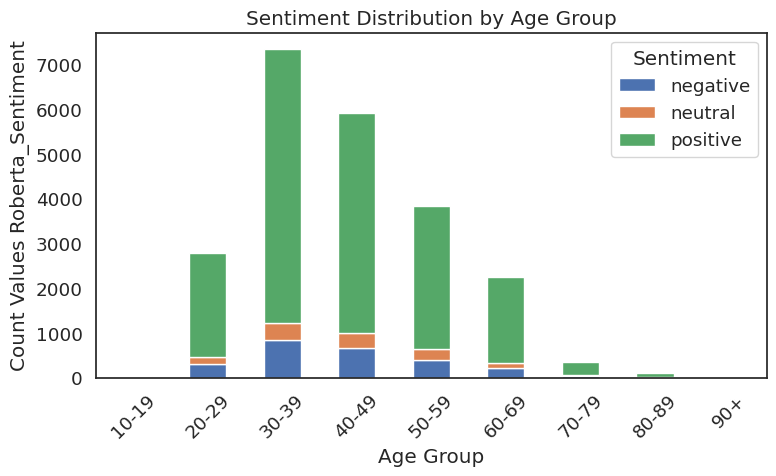

In [10]:
# Group the data by 'age_group' and 'sentiment' and calculate counts
grouped = results_df.groupby(['age_group', 'roberta_sentiment']).size().unstack(fill_value=0)

# Plot the grouped data as a stacked bar plot
grouped.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.xticks(rotation=45)
plt.title('Sentiment Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count Values Roberta_Sentiment')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Applied AI Assesment/roberta_age_group.png")
plt.show()

# THE CNN-LSTM MODEL
### The CNN-LSTM MODEL is used to measure the accuracy of our sentimental analysis using word embedding and 1 hidden layer with softmax activation function, sparse_categorical_crossentropy, adam optimizer, dropout and recurrent_dropout

## Using the Roberta sentiment as the label for the CNN-LSTM MODEL

Epoch 1/10
510/510 - 219s - loss: 0.4307 - accuracy: 0.8521 - val_loss: 0.5173 - val_accuracy: 0.8647 - 219s/epoch - 430ms/step
Epoch 2/10
510/510 - 254s - loss: 0.2887 - accuracy: 0.8936 - val_loss: 0.3558 - val_accuracy: 0.8708 - 254s/epoch - 499ms/step
Epoch 3/10
510/510 - 234s - loss: 0.2254 - accuracy: 0.9154 - val_loss: 0.3637 - val_accuracy: 0.8708 - 234s/epoch - 458ms/step
142/142 [==============================] - 10s 66ms/step - loss: 0.3448 - accuracy: 0.8741
Test Loss: 0.3448, Test Accuracy: 0.8741


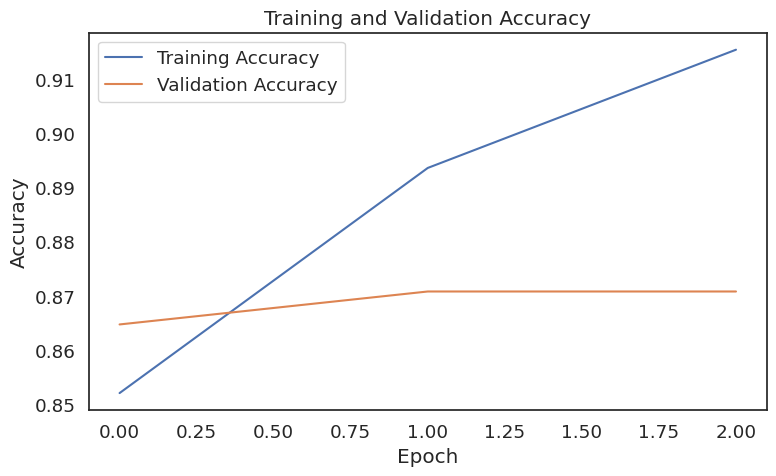

In [59]:
# Load and preprocess your review data

reviews = results_df['Review Text'].tolist()
labels = results_df['roberta_sentiment'].tolist()

# Perform label encoding on sentiment labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=42)

# Tokenize and pad sequences
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the LSTM model
num_classes = len(label_encoder.classes_)  # Number of sentiment classes

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))  # Use 'softmax' for multi-class classification

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the model
epochs = 10
batch_size = 32
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping], verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, batch_size=batch_size)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# plotting the training and validation accuracy for the model
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Applied AI Assesment/roberta_accuracy.png")
plt.show()

## Training an LSTM-CNN sentimental classifier using the VADER sentiment scores

Epoch 1/10
510/510 - 239s - loss: 0.5071 - accuracy: 0.8260 - val_loss: 0.4377 - val_accuracy: 0.8371 - 239s/epoch - 468ms/step
Epoch 2/10
510/510 - 204s - loss: 0.3637 - accuracy: 0.8666 - val_loss: 0.4209 - val_accuracy: 0.8459 - 204s/epoch - 400ms/step
Epoch 3/10
510/510 - 206s - loss: 0.2857 - accuracy: 0.8968 - val_loss: 0.4675 - val_accuracy: 0.8443 - 206s/epoch - 404ms/step
Epoch 4/10
510/510 - 207s - loss: 0.2323 - accuracy: 0.9182 - val_loss: 0.4656 - val_accuracy: 0.8415 - 207s/epoch - 406ms/step
142/142 [==============================] - 6s 43ms/step - loss: 0.4028 - accuracy: 0.8535
Test Loss: 0.4028, Test Accuracy: 0.8535


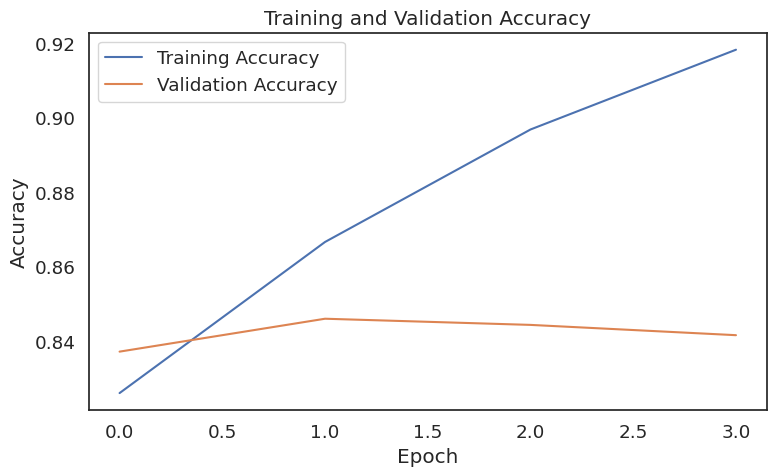

In [52]:
# Load and preprocess your review data

reviews = results_df['Review Text'].tolist()
labels = results_df['VADER_sentiment'].tolist()

# Perform label encoding on sentiment labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=42)

# Tokenize and pad sequences
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the LSTM model
num_classes = len(label_encoder.classes_)  # Number of sentiment classes

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))  # Use 'softmax' for multi-class classification

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
epochs = 10
batch_size = 32
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping], verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, batch_size=batch_size)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# plotting the training and validation accuracy for the model
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Applied AI Assesment/VADER_accuracy.png")
plt.show()

## Hyperparameter tuning of the model using the roberta_sentiment scores

In [ ]:
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.preprocessing import LabelEncoder
# from keras.models import Sequential
# from keras.layers import Embedding, LSTM, Dense
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# Load your data and perform label encoding as shown in your original code
reviews = results_df['Review Text'].tolist()
labels = results_df['roberta_sentiment'].tolist()

# Perform label encoding on sentiment labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=42)

# Tokenize and pad sequences
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the LSTM model
num_classes = len(label_encoder.classes_)  # Number of sentiment classes

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'lstm_units': [64, 128],         # Experiment with different values
    'dense_units': [64, 128],
    'learning_rate': [0.001, 0.01],
    'epochs': [5],
}

# Define the LSTM model creation function
def create_lstm_model(lstm_units, dense_units, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))  # Fixed embedding_output_dim
    model.add(LSTM(lstm_units))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the LSTM model
lstm_model = KerasClassifier(build_fn=create_lstm_model)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, scoring='accuracy', cv=2)

# Fit the grid search to the data
grid_search.fit(X_train_pad, y_train)

# Print the best parameters and best accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)


<ipython-input-7-0c2d0dc46765>:52: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasClassifier(build_fn=create_lstm_model)


Epoch 1/5
283/283 [==============================] - 62s 205ms/step - loss: 0.4883 - accuracy: 0.8436
Epoch 2/5
283/283 [==============================] - 56s 199ms/step - loss: 0.3220 - accuracy: 0.8835
Epoch 3/5
283/283 [==============================] - 56s 197ms/step - loss: 0.2400 - accuracy: 0.9093
Epoch 4/5
283/283 [==============================] - 55s 193ms/step - loss: 0.1789 - accuracy: 0.9358
Epoch 5/5
283/283 [==============================] - 14s 47ms/step
Epoch 1/5
283/283 [==============================] - 57s 192ms/step - loss: 0.4937 - accuracy: 0.8373
Epoch 2/5
283/283 [==============================] - 59s 207ms/step - loss: 0.3163 - accuracy: 0.8833
Epoch 3/5
283/283 [==============================] - 55s 194ms/step - loss: 0.2362 - accuracy: 0.9104
Epoch 4/5
283/283 [==============================] - 55s 193ms/step - loss: 0.1711 - accuracy: 0.9383
Epoch 5/5
283/283 [==============================] - 12s 39ms/step
Epoch 1/5
283/283 [==============================]

## Hyperparameter tuning of the model

Epoch 1/5
510/510 [==============================] - 359s 695ms/step - loss: 0.4323 - accuracy: 0.8498 - val_loss: 0.3819 - val_accuracy: 0.8581
Epoch 2/5
510/510 [==============================] - 345s 677ms/step - loss: 0.3018 - accuracy: 0.8875 - val_loss: 0.3809 - val_accuracy: 0.8691
Epoch 3/5
142/142 [==============================] - 13s 92ms/step - loss: 0.3548 - accuracy: 0.8767
Test Loss: 0.3548344075679779
Test Accuracy: 0.8767123222351074


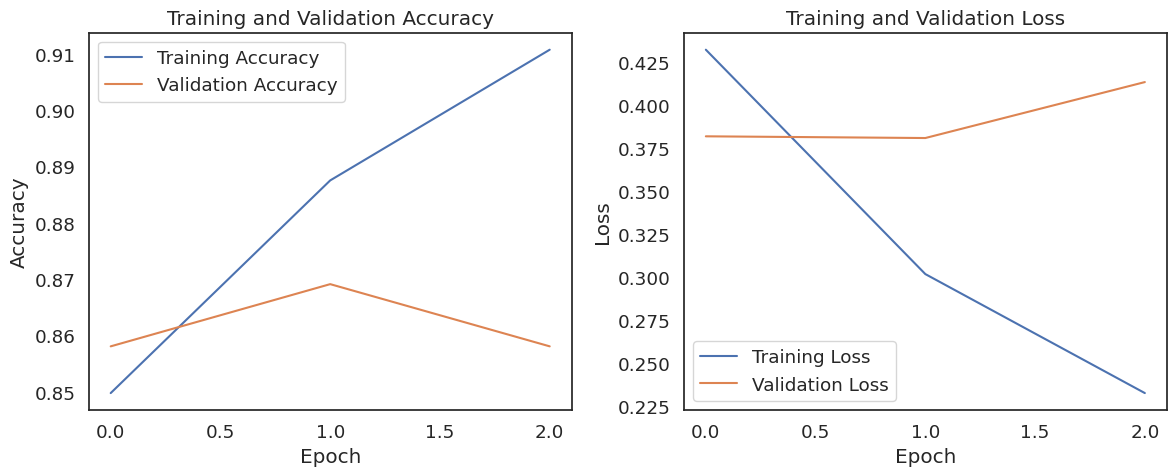

In [61]:
# Load and preprocess your review data

reviews = results_df['Review Text'].tolist()
labels = results_df['roberta_sentiment'].tolist()

# Perform label encoding on sentiment labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=42)

# Tokenize and pad sequences
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Defining the early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)


# Best hyperparameters
best_params = {'dense_units': 64, 'epochs': 5, 'learning_rate': 0.01, 'lstm_units': 128}

num_classes = len(label_encoder.classes_)

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(best_params['lstm_units'], dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(best_params['dense_units'], activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=best_params['epochs'], batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

# Save the plots
plt.savefig("/content/drive/MyDrive/Applied AI Assesment/hyperparametr_roberta_metrics.png")

# Show the plots
plt.show()


## Mismatch: Where we have positive sentiment with low Rating

# Mismatch Analysis.
## Exploring where the model did the opposite of what it should. This means where the rating is highest (5) but the sentiment is classified as negative or where the Rating is lowest(1) but the sentiment is classified as positive
## The reason for this is the based on human perception, someone who is willing to give a positve feedback will not end up giving a negative review or someone who is willing to give negative feedback will not give a high rating.

## Second Case of mismatch: Where Rating is low (1) but sentiment is positive

In [62]:

results_df[(results_df["Rating"] == 1) & (results_df["roberta_sentiment"] == "positive")]

,ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Age,Review Text,Rating,Class Name,roberta_sentiment,VADER_sentiment,age_group
95,97,0.000,0.665,0.335,0.8903,0.006896,0.025672,0.967432,44,I was very excited to order this top in red xs...,1,Knits,positive,positive,40-49
200,209,0.000,0.840,0.160,0.7579,0.004081,0.029336,0.966583,44,Love the fabric of this shirt even though it w...,1,Knits,positive,positive,40-49
232,241,0.043,0.828,0.129,0.8492,0.096205,0.193240,0.710555,32,I loved this dress from the moment i tried it ...,1,Lounge,positive,positive,30-39
602,632,0.000,0.629,0.371,0.9293,0.007398,0.104847,0.887755,48,This top looked super cute online but when it ...,1,Blouses,positive,positive,40-49
616,646,0.144,0.745,0.112,-0.5067,0.136886,0.364950,0.498164,37,I waited three months for these pants. when th...,1,Pants,positive,negative,30-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22133,22975,0.137,0.715,0.148,0.2163,0.246165,0.233010,0.520825,44,I loved these pants and purchased them in thre...,1,Pants,positive,negative,40-49
22140,22982,0.022,0.880,0.099,0.7761,0.018613,0.304963,0.676424,36,After reading the other reviews i still took a...,1,Dresses,positive,positive,30-39
22251,23100,0.089,0.744,0.166,0.6249,0.114716,0.238935,0.646348,48,"I love the colors. however, $200 is a lot to p...",1,Dresses,positive,positive,40-49
22420,23274,0.057,0.861,0.082,0.3612,0.032320,0.186536,0.781145,29,"I'm 5'7"" 155lbs and ordered a large. it fit, b...",1,Knits,positive,negative,20-29


## Example of the Mismatch analysis where rating is low and sentiment is positive

In [21]:
results_df[(results_df["Rating"] == 1) & (results_df["roberta_sentiment"] == "positive")]["Review Text"].values[0]

"I was very excited to order this top in red xs. so cute, but it was huge, shapeless and support thin! it had to go back. i should've looked at other reviews."

## Second Case of mismatch: Where Rating is High (5) but sentiment is negative

In [63]:
results_df[(results_df["Rating"] == 5) & (results_df["roberta_sentiment"] == "negative")]

,ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Age,Review Text,Rating,Class Name,roberta_sentiment,VADER_sentiment,age_group
173,180,0.240,0.602,0.158,-0.5284,0.364584,0.338440,0.296976,39,"Loved the green color, the cut is super flatte...",5,Fine gauge,negative,negative,30-39
576,605,0.048,0.792,0.160,0.8020,0.673369,0.237984,0.088648,59,I am returning the dress because it smells hea...,5,Dresses,negative,positive,50-59
806,845,0.000,1.000,0.000,0.0000,0.678181,0.293556,0.028263,38,Unusual color. expensive even on sale.,5,Trend,negative,negative,30-39
1047,1092,0.176,0.476,0.348,0.5574,0.341603,0.337504,0.320893,72,Great that it's hand washable because i hate t...,5,Blouses,negative,neutral,70-79
1510,1566,0.160,0.816,0.024,-0.9137,0.788973,0.175311,0.035716,49,I tried these on at the store and thought the ...,5,Pants,negative,negative,40-49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21553,22375,0.068,0.634,0.297,0.7814,0.584335,0.328992,0.086673,53,This is a pretty tunic but it just didn't look...,5,Dresses,negative,positive,50-59
21912,22748,0.046,0.716,0.237,0.9584,0.590563,0.301662,0.107775,47,I have the raspberry jumper and i feel like ro...,5,Pants,negative,positive,40-49
22112,22953,0.049,0.951,0.000,-0.4973,0.514541,0.417193,0.068266,39,Per reviews and from looking at retailer emplo...,5,Dresses,negative,negative,30-39
22120,22962,0.064,0.911,0.025,-0.4577,0.645746,0.312014,0.042240,49,My daughter got this dress in the 10 and i got...,5,Dresses,negative,negative,40-49


## Example of the Mismatch analysis where rating is high and sentiment is negative

In [24]:
results_df[(results_df["Rating"] == 5) & (results_df["roberta_sentiment"] == "negative")]["Review Text"].values[0]

'Loved the green color, the cut is super flattering, but alas, i do need hte petite, ti was a bit long and i looked a little lost. unfrotuantely, the color is sold out in petite :-('

### From the above, it is evident that this is a positive response but the rating is lowest. This shows an instance of mismatch between the rating and the sentiment scores. To better understand this instance. I will convert the roberta and VADER polarity into positive, negative, and neutral, train a CNN model with LSTM on the model and measure the accuracy.

In [64]:
results_df1 =results_df.copy()

# Converting negative sentiment to positive where Rating is High (5) but the sentiment is negative
results_df1.loc[(results_df1["Rating"] == 5) & (results_df1["roberta_sentiment"] == "negative"), "roberta_sentiment"] = "positive"


# Converting positive sentiment to negative where Rating is low (1) but the sentiment is positive
results_df1.loc[(results_df1["Rating"] == 1) & (results_df1["roberta_sentiment"] == "positive"), "roberta_sentiment"] = "negative"

## Training the CNN-LSTM model again using the mimatch corrected data gives

Epoch 1/5
510/510 [==============================] - 358s 682ms/step - loss: 0.4436 - accuracy: 0.8468 - val_loss: 0.4303 - val_accuracy: 0.8625
Epoch 2/5
510/510 [==============================] - 350s 685ms/step - loss: 0.3098 - accuracy: 0.8847 - val_loss: 0.4255 - val_accuracy: 0.8642
Epoch 3/5
510/510 [==============================] - 348s 682ms/step - loss: 0.2468 - accuracy: 0.9084 - val_loss: 0.4119 - val_accuracy: 0.8658
Epoch 4/5
510/510 [==============================] - 346s 680ms/step - loss: 0.1905 - accuracy: 0.9280 - val_loss: 0.4352 - val_accuracy: 0.8327
Epoch 5/5
142/142 [==============================] - 12s 85ms/step - loss: 0.3863 - accuracy: 0.8714
Test Loss: 0.38625600934028625
Test Accuracy: 0.8714096546173096


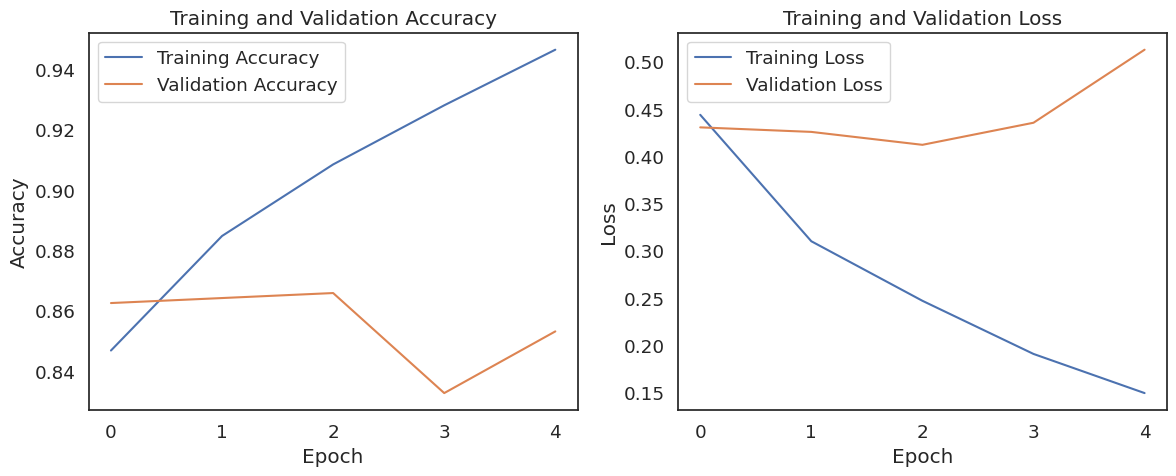

In [66]:

# Load and preprocess your data as before


reviews = results_df1['Review Text'].tolist()
labels = results_df1['roberta_sentiment'].tolist()

# Perform label encoding on sentiment labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=42)

# Tokenize and pad sequences
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Defining the early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


# Best hyperparameters
best_params = {'dense_units': 64, 'epochs': 5, 'learning_rate': 0.01, 'lstm_units': 128}

num_classes = len(label_encoder.classes_)

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(best_params['lstm_units'], dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(best_params['dense_units'], activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=best_params['epochs'], batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

# Save the plots
plt.savefig("/content/drive/MyDrive/Applied AI Assesment/mismatch_roberta_metrics.png")

# Show the plots
plt.show()